In [1]:
from IPython.core.debugger import Tracer
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models
import argparse
from datetime import datetime
import os
import time
import multiprocessing
import psutil
import json
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  
import h5py
from sklearn.model_selection import train_test_split
from skimage.util import crop,  random_noise
from skimage.transform import   rescale, resize, rotate, AffineTransform, warp
import torch.optim as optim
from tqdm import tqdm
import copy
from collections import Counter
from PIL import Image
from pathlib import Path
import warnings
from monai.utils import ensure_tuple, optional_import
from IPython.core.debugger import Tracer
from copy import deepcopy
from monai.transforms.compose import Transform
from monai.transforms import \
    Compose, LoadPNG, AddChannel, ScaleIntensity, ToTensor, RandRotate, RandFlip, RandZoom
from monai.metrics import compute_roc_auc, compute_occlusion_sensitivity
from collections.abc import Sequence
from functools import partial
from typing import Dict, List, Optional, Sequence, Union

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import seaborn as sns
import random

In [2]:
data_dir = 'data/CellCycle'
class_names = sorted([x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x))])
num_class = len(class_names)
all_files = [[os.path.join(data_dir, class_name, x) 
                for x in os.listdir(os.path.join(data_dir, class_name))] 
               for class_name in class_names]
image_files = [list(set([os.path.join(data_dir, class_name, x.split("_")[0]) 
                for x in os.listdir(os.path.join(data_dir, class_name))])) 
               for class_name in class_names]
image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)
image_width, image_height = Image.open(all_files[0][0]).size

print('Total image count:', num_total)
print("Image dimensions:", image_width, "x", image_height)
print("Label names:", class_names)
print("Label counts:", [len(image_files[i]) for i in range(num_class)])

Total image count: 32266
Image dimensions: 66 x 66
Label names: ['Anaphase', 'G1', 'G2', 'Metaphase', 'Prophase', 'S', 'Telophase']
Label counts: [15, 14333, 8601, 68, 606, 8616, 27]


In [3]:
flat_list = [item for sublist in all_files for item in sublist]

x = []
y = []
for i in flat_list:
    im = Image.open(i)
    Tracer()()
    width, height = im.size
    x.append(width)
    y.append(height)
    if width != 66 or height != 66:
        print(i)
plt.scatter(x, y)
plt.show()

In [4]:
valid_frac, test_frac = 0.1, 0.1
trainX, trainY = [], []
valX, valY = [], []
testX, testY = [], []

for i in range(num_total):
    rann = np.random.random()
    if rann < valid_frac:
        valX.append(image_file_list[i])
        valY.append(image_label_list[i])
    elif rann < test_frac + valid_frac:
        testX.append(image_file_list[i])
        testY.append(image_label_list[i])
    else:
        trainX.append(image_file_list[i])
        trainY.append(image_label_list[i])

print("Training count =",len(trainX),"Validation count =", len(valX), "Test count =",len(testX))

Training count = 25790 Validation count = 3185 Test count = 3291


In [5]:
class LoadImage(Transform):
    """
    Load common 2D image format (PNG, JPG, etc. using PIL) file or files from provided path.
    If loading a list of files, stack them together and add a new dimension as first dimension,
    and use the meta data of the first image to represent the stacked result.
    It's based on the Image module in PIL library:
    https://pillow.readthedocs.io/en/stable/reference/Image.html
    """

    def __init__(self, only_channels = []) -> None:
        self.only_channels = only_channels

    def __call__(self, name: Union[Sequence[Union[Path, str]], Path, str]):
        img_array = list()
        class_dir = os.path.dirname(name)
        sample_id = os.path.basename(name) + "_Ch"
        channels = [np.asarray(Image.open(os.path.join(class_dir, file)))/255. for file in os.listdir(class_dir) if file.startswith(sample_id)]
        #Tracer()()
        image = np.stack(channels, axis = 2)
        image_RGB = image*255
        return Image.fromarray(np.uint8(image_RGB))
        #img_array.append(image)
        #img_array = np.stack(img_array, axis=0) if len(img_array) > 1 else img_array[0]
        #return image

In [6]:
class ToTensorCustom(Transform):
    """
    Converts the input image to a tensor without applying any other transformations.
    """

    def __call__(self, img: Union[np.ndarray, torch.Tensor]) -> torch.Tensor:
        """
        Apply the transform to `img` and make it contiguous.
        """
        #img = np.asarray(img)
        #image = torch.from_numpy(copy.deepcopy(img))
        if torch.is_tensor(img):
            return img.contiguous().T
        return torch.as_tensor(np.ascontiguousarray(img) / 255.).T

In [7]:
train_transforms = transforms.Compose([
    LoadImage(),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    ToTensorCustom()
])
val_transforms = transforms.Compose([
    LoadImage(),
    ToTensorCustom()
])

In [8]:
class JurkatDataset(Dataset):

    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

train_ds = JurkatDataset(trainX, trainY, train_transforms)
train_loader = DataLoader(train_ds, batch_size=300, shuffle=True, num_workers=10)

val_ds = JurkatDataset(valX, valY, val_transforms)
val_loader = DataLoader(val_ds, batch_size=300, num_workers=10)

test_ds = JurkatDataset(testX, testY, val_transforms)
test_loader = DataLoader(test_ds, batch_size=300, num_workers=10)

In [9]:
def plot_heatmap_3_channels(heatmap):
    fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15,15))
    #plt.figure(figsize=(20,10))
    ax1.imshow(heatmap[0])
    ax2.imshow(heatmap[1])
    ax3.imshow(heatmap[2])

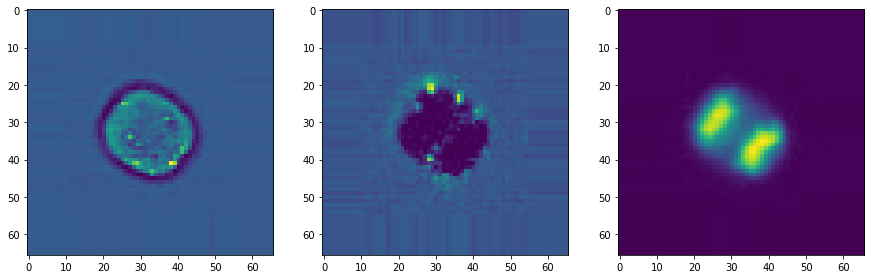

In [10]:
plot_heatmap_3_channels(test_ds[0][0])

In [14]:
resnet18 = models.resnet18(pretrained=True)
device = "cpu"
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# change first layer
#model_ft.conv1 = torch.nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = resnet18.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
resnet18.fc = nn.Linear(num_ftrs, num_class)

resnet18 = resnet18.to(device)

loss_function = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(resnet18.parameters(), 1e-5)
#optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)
 
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [15]:
epoch_num = 10
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    resnet18.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device).float(), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = resnet18(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        resnet18.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device).float(), val_data[1].to(device)
                y_pred = torch.cat([y_pred, resnet18(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            #Tracer()()
            auc_metric = compute_roc_auc(y_pred, y, to_onehot_y=True, softmax=True)
            metric_values.append(auc_metric)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if auc_metric > best_metric:
                best_metric = auc_metric
                best_metric_epoch = epoch + 1
                torch.save(resnet18.state_dict(), 'models/best_metric_model_jurkat.pth')
                print('saved new best metric model')
            print(f"current epoch: {epoch + 1} current AUC: {auc_metric:.4f}"
                  f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/10
1/85, train_loss: 2.5398
2/85, train_loss: 2.4535
3/85, train_loss: 2.4273
4/85, train_loss: 2.4053
5/85, train_loss: 2.3939
6/85, train_loss: 2.3556
7/85, train_loss: 2.4100
8/85, train_loss: 2.2947
9/85, train_loss: 2.3218
10/85, train_loss: 2.2501
11/85, train_loss: 2.2738
12/85, train_loss: 2.2394
13/85, train_loss: 2.2396
14/85, train_loss: 2.2006
15/85, train_loss: 2.2022
16/85, train_loss: 2.1128
17/85, train_loss: 2.0748
18/85, train_loss: 2.0727
19/85, train_loss: 2.1097
20/85, train_loss: 2.1136
21/85, train_loss: 2.0384
22/85, train_loss: 2.0469
23/85, train_loss: 2.0414
24/85, train_loss: 2.0825
25/85, train_loss: 1.9846
26/85, train_loss: 1.9097
27/85, train_loss: 1.9489
28/85, train_loss: 1.8837
29/85, train_loss: 1.9467
30/85, train_loss: 1.9367
31/85, train_loss: 1.8550
32/85, train_loss: 1.8959
33/85, train_loss: 1.8041
34/85, train_loss: 1.8384
35/85, train_loss: 1.7878
36/85, train_loss: 1.7987
37/85, train_loss: 1.7174
38/85, train_loss: 1.7439

40/85, train_loss: 0.7922
41/85, train_loss: 0.7470
42/85, train_loss: 0.7443
43/85, train_loss: 0.7114
44/85, train_loss: 0.7225
45/85, train_loss: 0.7858
46/85, train_loss: 0.6771
47/85, train_loss: 0.6733
48/85, train_loss: 0.6686
49/85, train_loss: 0.7379
50/85, train_loss: 0.6189
51/85, train_loss: 0.7164
52/85, train_loss: 0.7449
53/85, train_loss: 0.7342
54/85, train_loss: 0.6460
55/85, train_loss: 0.8101
56/85, train_loss: 0.7336
57/85, train_loss: 0.7594
58/85, train_loss: 0.7102
59/85, train_loss: 0.6839
60/85, train_loss: 0.6259
61/85, train_loss: 0.6914
62/85, train_loss: 0.7598
63/85, train_loss: 0.8629
64/85, train_loss: 0.6443
65/85, train_loss: 0.7636
66/85, train_loss: 0.7280
67/85, train_loss: 0.6789
68/85, train_loss: 0.7125
69/85, train_loss: 0.6784
70/85, train_loss: 0.6759
71/85, train_loss: 0.7220
72/85, train_loss: 0.7020
73/85, train_loss: 0.7501
74/85, train_loss: 0.6057
75/85, train_loss: 0.6674
76/85, train_loss: 0.6492
77/85, train_loss: 0.6817
78/85, train

79/85, train_loss: 0.6041
80/85, train_loss: 0.5819
81/85, train_loss: 0.5570
82/85, train_loss: 0.6220
83/85, train_loss: 0.5857
84/85, train_loss: 0.6739
85/85, train_loss: 0.6346
86/85, train_loss: 0.6709
epoch 7 average loss: 0.6348
current epoch: 7 current AUC: 0.8008 current accuracy: 0.7378 best AUC: 0.8042 at epoch: 6
----------
epoch 8/10
1/85, train_loss: 0.5936
2/85, train_loss: 0.6026
3/85, train_loss: 0.5527
4/85, train_loss: 0.7107
5/85, train_loss: 0.6574
6/85, train_loss: 0.6077
7/85, train_loss: 0.5915
8/85, train_loss: 0.5297
9/85, train_loss: 0.5984
10/85, train_loss: 0.6943
11/85, train_loss: 0.6905
12/85, train_loss: 0.5494
13/85, train_loss: 0.6584
14/85, train_loss: 0.6107
15/85, train_loss: 0.5911
16/85, train_loss: 0.6292
17/85, train_loss: 0.5902
18/85, train_loss: 0.5786
19/85, train_loss: 0.6189
20/85, train_loss: 0.6604
21/85, train_loss: 0.6404
22/85, train_loss: 0.6445
23/85, train_loss: 0.6321
24/85, train_loss: 0.5967
25/85, train_loss: 0.5664
26/85, tr

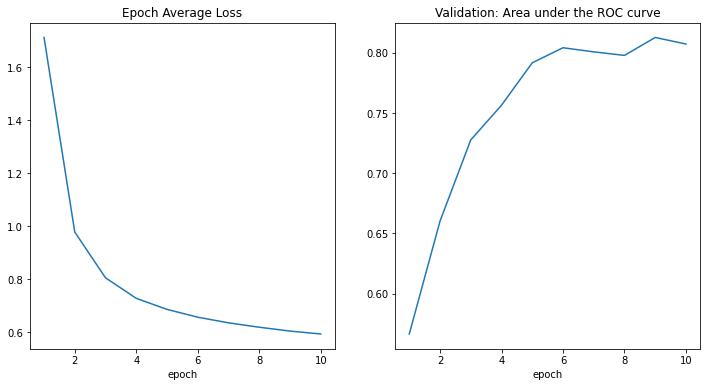

In [16]:
plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Validation: Area under the ROC curve")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.show()

In [17]:
model = models.resnet18(pretrained=True)
device = "cpu"
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# change first layer
#model_ft.conv1 = torch.nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, num_class)

model = model.to(device)
model.load_state_dict(torch.load('models/best_metric_model_jurkat.pth', map_location=torch.device(device)))

<All keys matched successfully>

In [18]:
epoch_num = 10
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device).float(), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device).float(), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            #Tracer()()
            auc_metric = compute_roc_auc(y_pred, y, to_onehot_y=True, softmax=True)
            metric_values.append(auc_metric)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if auc_metric > best_metric:
                best_metric = auc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'models/best_metric_model_jurkat.pth')
                print('saved new best metric model')
            print(f"current epoch: {epoch + 1} current AUC: {auc_metric:.4f}"
                  f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/10
1/85, train_loss: 0.6565
2/85, train_loss: 0.5733
3/85, train_loss: 0.6072
4/85, train_loss: 0.5459
5/85, train_loss: 0.5950
6/85, train_loss: 0.6007
7/85, train_loss: 0.5403
8/85, train_loss: 0.6322
9/85, train_loss: 0.6749
10/85, train_loss: 0.6751
11/85, train_loss: 0.6391
12/85, train_loss: 0.5951
13/85, train_loss: 0.5125
14/85, train_loss: 0.5357
15/85, train_loss: 0.6197
16/85, train_loss: 0.5455
17/85, train_loss: 0.6713
18/85, train_loss: 0.5687
19/85, train_loss: 0.5657
20/85, train_loss: 0.6359
21/85, train_loss: 0.6318
22/85, train_loss: 0.5091
23/85, train_loss: 0.6310
24/85, train_loss: 0.4869
25/85, train_loss: 0.6065
26/85, train_loss: 0.6385
27/85, train_loss: 0.5378
28/85, train_loss: 0.5523
29/85, train_loss: 0.5711
30/85, train_loss: 0.5224
31/85, train_loss: 0.6650
32/85, train_loss: 0.5771
33/85, train_loss: 0.6011
34/85, train_loss: 0.5318
35/85, train_loss: 0.5969
36/85, train_loss: 0.5411
37/85, train_loss: 0.6289
38/85, train_loss: 0.6607

42/85, train_loss: 0.6560
43/85, train_loss: 0.5894
44/85, train_loss: 0.5938
45/85, train_loss: 0.5878
46/85, train_loss: 0.6039
47/85, train_loss: 0.5864
48/85, train_loss: 0.5904
49/85, train_loss: 0.5506
50/85, train_loss: 0.6649
51/85, train_loss: 0.5384
52/85, train_loss: 0.5952
53/85, train_loss: 0.5851
54/85, train_loss: 0.6107
55/85, train_loss: 0.6580
56/85, train_loss: 0.5912
57/85, train_loss: 0.6709
58/85, train_loss: 0.5330
59/85, train_loss: 0.5450
60/85, train_loss: 0.5923
61/85, train_loss: 0.6250
62/85, train_loss: 0.5764
63/85, train_loss: 0.5710
64/85, train_loss: 0.6219
65/85, train_loss: 0.5379
66/85, train_loss: 0.5841
67/85, train_loss: 0.6320
68/85, train_loss: 0.6615
69/85, train_loss: 0.6076
70/85, train_loss: 0.6172
71/85, train_loss: 0.5416
72/85, train_loss: 0.6407
73/85, train_loss: 0.5493
74/85, train_loss: 0.6095
75/85, train_loss: 0.6069
76/85, train_loss: 0.6321
77/85, train_loss: 0.5680
78/85, train_loss: 0.5524
79/85, train_loss: 0.5539
80/85, train

83/85, train_loss: 0.5835
84/85, train_loss: 0.5902
85/85, train_loss: 0.6609
86/85, train_loss: 0.5853
epoch 7 average loss: 0.5938
current epoch: 7 current AUC: 0.8108 current accuracy: 0.7469 best AUC: 0.8110 at epoch: 4
----------
epoch 8/10
1/85, train_loss: 0.6277
2/85, train_loss: 0.5292
3/85, train_loss: 0.5618
4/85, train_loss: 0.5861
5/85, train_loss: 0.6216
6/85, train_loss: 0.5045
7/85, train_loss: 0.5660
8/85, train_loss: 0.5961
9/85, train_loss: 0.5831
10/85, train_loss: 0.5892
11/85, train_loss: 0.5993
12/85, train_loss: 0.5701
13/85, train_loss: 0.6151
14/85, train_loss: 0.6563
15/85, train_loss: 0.5958
16/85, train_loss: 0.5999
17/85, train_loss: 0.5564
18/85, train_loss: 0.6081
19/85, train_loss: 0.7312
20/85, train_loss: 0.5394
21/85, train_loss: 0.5586
22/85, train_loss: 0.6302
23/85, train_loss: 0.5723
24/85, train_loss: 0.5881
25/85, train_loss: 0.5781
26/85, train_loss: 0.5546
27/85, train_loss: 0.6056
28/85, train_loss: 0.6348
29/85, train_loss: 0.6644
30/85, tr

In [19]:
model.load_state_dict(torch.load('models/best_metric_model_jurkat.pth'))
model.eval()
y_true = list()
y_pred = list()
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device).float(), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

    Anaphase     0.0000    0.0000    0.0000         1
          G1     0.7990    0.9124    0.8519      1438
          G2     0.8048    0.7508    0.7769       895
   Metaphase     0.0000    0.0000    0.0000         8
    Prophase     0.7273    0.1250    0.2133        64
           S     0.5965    0.5437    0.5689       881
   Telophase     0.0000    0.0000    0.0000         4

    accuracy                         0.7508      3291
   macro avg     0.4182    0.3331    0.3444      3291
weighted avg     0.7418    0.7508    0.7400      3291



/home/aleksandra/anaconda3/envs/monai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aleksandra/anaconda3/envs/monai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aleksandra/anaconda3/envs/monai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,